## Introduction and Schema Diagram

We will be working with the Chinook database. A schema diagram of the database is provided below.

![Alt text](Frame.png)

## Selecting Alubms to Purchase
The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
choices = pd.DataFrame({'Artist Name':['Regal','Red Tone', 'Meteor and the Girls', 'Slim Jim Bites'],
                        'Genre':['Hip-Hop', 'Punk', 'Pop', 'Blues']})
choices

,Artist Name,Genre
0,Regal,Hip-Hop
1,Red Tone,Punk
2,Meteor and the Girls,Pop
3,Slim Jim Bites,Blues


## Creating Helper Functions

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''SELECT name, type
         FROM sqlite_master
         WHERE type IN ('table','view');'''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [4]:
q1 = '''
     SELECT g.name 'genre', 
            SUM(il.quantity) 'track_absolute', 
            (CAST(SUM(il.quantity) as float) / (SELECT TOTAL(il.quantity) 'total' 
                                                FROM invoice_line il INNER JOIN invoice i ON il.invoice_id = i.invoice_id
                                                WHERE i.billing_country = 'USA') * 100) 'track_percentages'
     FROM track t INNER JOIN invoice_line il ON t.track_id = il.track_id
                  INNER JOIN invoice i ON il.invoice_id = i.invoice_id
                  INNER JOIN genre g ON g.genre_id = t.genre_id
     WHERE i.billing_country = "USA"
     GROUP BY 1
     ORDER BY 3 DESC
     '''

genre_sales_usa = run_query(q1)
run_query(q1)

,genre,track_absolute,track_percentages
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Pop,22,2.093245
7,Latin,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


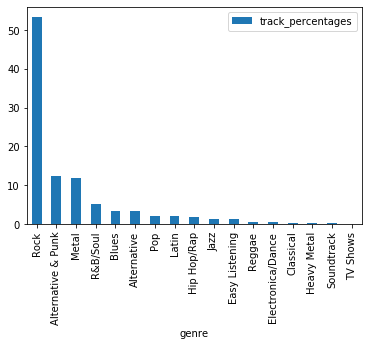

In [5]:
genre_sales_usa.set_index('genre', drop = True, inplace = True)
genre_sales_usa.plot.bar(y = 'track_percentages')
plt.show()

According to our research, the Regal (Punk) and the Slim Jim Bites (Blues) albums should definitely be added to the record store. 
The Metoer and the Girls (Pop) and the Regal (Hip-Hop) albums are very close in popularity but since Pop comes out ahead in our research and Hip-Hop shares the category with Rap. The final album to add to the store is The Meteor and the Girls. 

---

## Analyzing Employees Sales Performance
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [7]:
q2 =''' 
WITH sales_support_agent AS
    (SELECT * FROM employee 
     WHERE title = 'Sales Support Agent'),
    total_sales AS
    (SELECT c.support_rep_id, 
            SUM(i.total) 'sales'
     FROM customer c INNER JOIN invoice i ON c.customer_id = i.customer_id
     GROUP BY 1
     ORDER BY 2 DESC)


SELECT ssa.first_name || ' ' || ssa.last_name 'employee_name', 
       ssa.hire_date 'hire_date',
       ts.sales 'total sales'
FROM sales_support_agent ssa INNER JOIN total_sales ts ON ssa.employee_id = ts.support_rep_id
ORDER BY 3 DESC
'''
sales_support = run_query(q2)
sales_support

,employee_name,hire_date,total sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


In [8]:
sales_support.set_index('employee_name', drop = True, inplace = True)

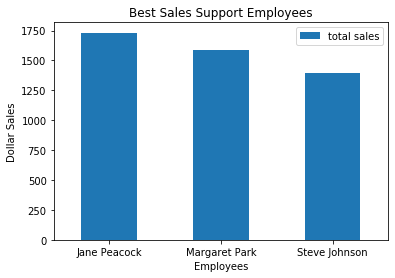

In [9]:
sales_support.plot.bar(y = 'total sales', title = 'Best Sales Support Employees', rot = 0)
plt.ylabel('Dollar Sales')
plt.xlabel('Employees')
plt.show()

Jane is the Sales Support Agent with the highest total sales, followed by Margaret and then Steve. However, it is good to notice that total sales correlates with how long they have been part of the company. Therefore, Jane has been working the longest and Steve the shortest.

---
## Analyzing Sales by Country
Your next task is to analyze the sales data for customers from each different country.
You have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, you have been directed to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In [10]:
q3 = ''' 
WITH first_iter AS
    (SELECT CASE WHEN 
                (SELECT COUNT(*) FROM customer
                 WHERE country = c.country) = 1
                THEN "Other"
                ELSE c.country
                END AS country, 
            COUNT(DISTINCT c.customer_id) total_customers, 
            SUM(i.total) total_sales, 
            SUM(i.total) / COUNT(DISTINCT c.customer_id) sales_per_customer, 
            SUM(i.total) / COUNT(i.invoice_id) sales_per_order
     FROM customer c INNER JOIN invoice i ON c.customer_id = i.customer_id
     GROUP BY 1
     ORDER BY 2 DESC),
     
     sort_other AS
     (SELECT fi.*,
             CASE WHEN fi.country = 'Other'
             THEN 1
             ELSE 0
             END AS sort
             FROM first_iter fi)
    
SELECT fi.* 
from first_iter fi INNER JOIN sort_other so ON fi.country = so.country 
ORDER BY so.sort;
       
'''
    

    
run_query(q3)


,country,total_customers,total_sales,sales_per_customer,sales_per_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,France,5,389.07,77.814000,7.781400
3,Brazil,5,427.68,85.536000,7.011148
4,Germany,4,334.62,83.655000,8.161463
5,United Kingdom,3,245.52,81.840000,8.768571
6,Portugal,2,185.13,92.565000,6.383793
7,India,2,183.15,91.575000,8.721429
8,Czech Republic,2,273.24,136.620000,9.108000
9,Other,15,1094.94,72.996000,7.448571


## Visualizing Sales by Country

In [11]:
country_metrics = run_query(q3)
country_metrics.set_index('country', drop = True, inplace = True)

In [12]:
import numpy as np
colors = [plt.cm.Accent(i) for i in np.linspace(0,1,country_metrics.shape[0])]


AttributeError: 'Rectangle' object has no property 'colors'

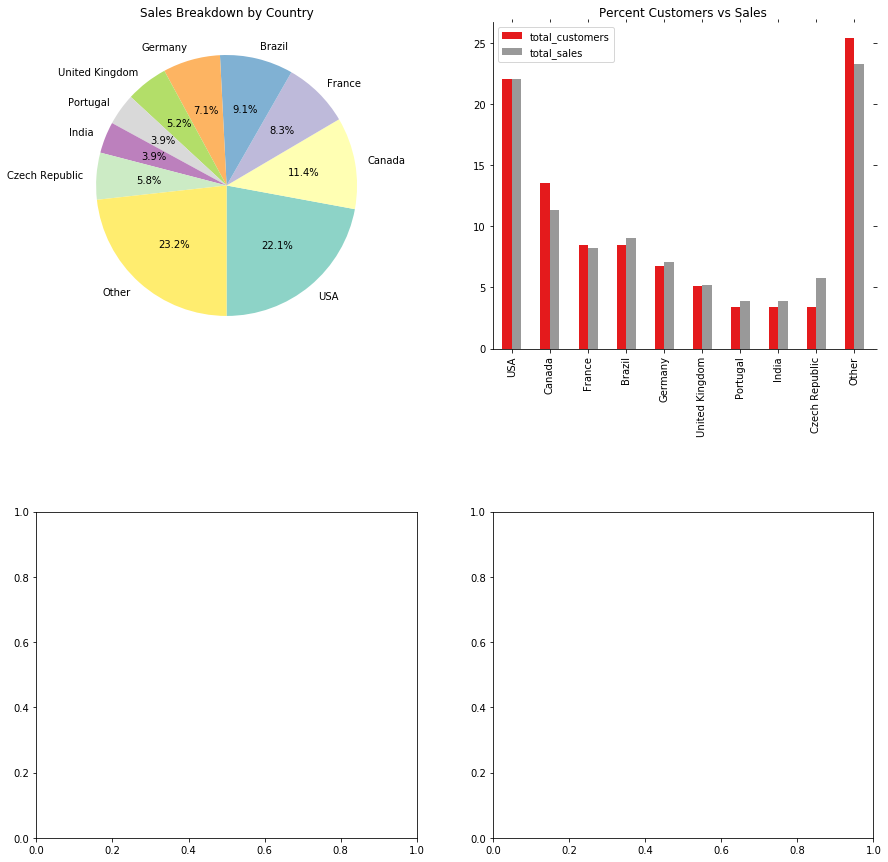

In [13]:
sales = country_metrics['total_sales'].copy().rename('')
fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(hspace=.5)
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

#top left
sales.plot.pie(ax = ax1, colormap = plt.cm.Set3,
               fontsize = 10,
               radius = 1,
              startangle = -90,
              title = ('Sales Breakdown by Country'),
              autopct = '%1.1f%%'
              )

cust_n_sales_col = ['total_customers', 'total_sales']
cust_n_sales = country_metrics[cust_n_sales_col].copy()
cust_n_sales.index.name = ''
pct_cust_sales = pd.DataFrame()
for i in cust_n_sales_col:
    pct_cust_sales[i] = (cust_n_sales[i]/cust_n_sales[i].sum()) *100

#top right
pct_cust_sales.plot.bar(ax = ax2, 
                        colormap = plt.cm.Set1, 
                        title = "Percent Customers vs Sales")
ax2.tick_params(top = 'off', bottom = 'off', left = 'off', right = 'off')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

#---

order = country_metrics['sales_per_order'].copy()
order.index.name = ''
pct_order = ((order - order.mean()) / order.mean()) * 100
pct_order.drop('Other', inplace = True)

#bottom left
pct_order.plot.bar(ax = ax3, 
                   colors = colors,
                   title = "Sales by Order from Mean"
                  )
ax3.tick_params(top = 'off', bottom = 'off', right = 'off', left = 'off')
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.axhline(0, color= 'k')

#bottom right

sales_p_cust = country_metrics['sales_per_customer'].copy()
sales_p_cust.index.name = ''
sales_p_cust.plot.bar(ax = ax4,
                      colors = colors,
                      title = 'Customer Lifetime Value')
ax4.tick_params(right = 'off', left = 'off', bottom = 'off', top = 'off')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)



The U.K., India and Czech Republic are the best countries to invest for the marketing campaigns. 
Czech Republic shows the highest potential. 
It is important to note that the data can be skewed due to a small sample size from these countries.

---
## Albums vs Individual Tracks


In [ ]:
qx ='''
WITH invoice_track AS
    (SELECT il.invoice_id invoice_id,
            MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1),
    
 album_track AS
    (SELECT t.album_id 
     FROM track t INNER JOIN invoice_track it ON it.first_track_id = t.track_id),

 invoice_line_track AS
    (SELECT il.track_id  
     FROM invoice_line il INNER JOIN invoice_track it ON il.invoice_id = it.invoice_id)
    
SELECT album_purchase,
       COUNT(invoice_id) number_of_invoices,
       ROUND(CAST(COUNT(invoice_id) as FLOAT) / (SELECT COUNT(*) FROM invoice) * 100,2) percentages
FROM
    (SELECT it.*,
     CASE WHEN
             (SELECT t.track_id FROM track t 
              WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                  WHERE t2.track_id = it.first_track_id)
              
              EXCEPT
              
              SELECT il2.track_id  
              FROM invoice_line il2 
              WHERE il2.invoice_id = it.invoice_id
             ) IS NULL
          AND
             (SELECT il2.track_id  
              FROM invoice_line il2 
              WHERE il2.invoice_id = it.invoice_id
             
              EXCEPT
              
              SELECT t.track_id FROM track t 
              WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                  WHERE t2.track_id = it.first_track_id)
             
             )IS NULL
         THEN 'yes'
         ELSE 'no'
     END AS 'album_purchase'
    FROM invoice_track it
    )
GROUP BY 1;
'''
run_query(qx)

Almost 20% of invoices are whole album sales. Chinook should continue to buy whole albums from record companies.